In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
import query_db
import composite
import spectral_analysis as sa
import scipy.interpolate as inter
from scipy.special import erf

In [87]:
# dm15 = (0.01828958)*x1^2 - 0.13430543*x1 + 1.02585001
# dm15 = 1.09 − 0.161x + 0.013x^2 − 0.00130x^3
x1_1 = 1.57
x1_2 = -.246
x1_3 = -1.12
x1_4 = -1.77
x1_5 = -2.90
x1_6 = -4.05
dm15s = [0.86, 1.06, 1.20, 1.32, 1.57, 1.87]
# x1_1 = 1.60
# x1_2 = 0.189
# x1_3 = -.647
# x1_4 = -1.28
# x1_5 = -2.40
# x1_6 = -3.51

In [88]:
phase_s, wavelength_salt, flux_salt = np.loadtxt('../data/info_files/SALT/salt2-4/salt2_template_0.dat', unpack = True)
phase_s_corr, wavelength_salt_corr, salt_corr = np.loadtxt('../data/info_files/SALT/salt2-4/salt2_template_1.dat', unpack = True)
flux_salt_1 = flux_salt + x1_1*salt_corr #dm15=0.86
flux_salt_2 = flux_salt + x1_2*salt_corr #dm15=1.06
flux_salt_3 = flux_salt + x1_3*salt_corr #dm15=1.20
flux_salt_4 = flux_salt + x1_4*salt_corr #dm15=1.32
flux_salt_5 = flux_salt + x1_5*salt_corr #dm15=1.57
flux_salt_6 = flux_salt + x1_6*salt_corr #dm15=1.87
flux_list = [flux_salt_1,flux_salt_2,flux_salt_3,flux_salt_4,flux_salt_5,flux_salt_6]

In [89]:
def make_salt_dict(phase_s, wavelength_salt, flux_salt):
    salt_dict = {}
    phase_list = []
    first = True
    for i, phase in enumerate(phase_s):
        if phase not in phase_list:
            phase_list.append(phase)
            if not first:
                salt_dict[float(phase_s[i-1])] = [temp_wave, temp_flux]
            temp_wave = [wavelength_salt[i]]
            temp_flux = [flux_salt[i]]
        else:
            temp_wave.append(wavelength_salt[i])
            temp_flux.append(flux_salt[i])
        first = False
    return salt_dict

In [90]:
def make_obj_from_template(wave, flux):
    wave_s = wave
    flux_s = flux
    wave_interp_s = np.arange(1000., 12000., dtype=int, step=2)
    flux_spl_s = inter.splrep(wave_s, flux_s)
    flux_interp_s = inter.splev(wave_interp_s, flux_spl_s, ext = 3)
    s_template = composite.supernova(wave_interp_s, flux_interp_s)
    s_template.phase_array = np.zeros(len(flux_interp_s))
    srange = np.where((wave_interp_s > 2000.) & (wave_interp_s < 9200))[0]
    s_template.x1 = srange[0]
    s_template.x2 = srange[-1]
    return s_template

In [91]:
s_temps = []
for f in flux_list:
    s_dict = make_salt_dict(phase_s, wavelength_salt, f)
    salt_temp = make_obj_from_template(s_dict[0.][0], s_dict[0.][1])
    s_temps.append(salt_temp)

In [92]:
import pyphot

In [93]:
lib = pyphot.get_library()
B = lib['GROUND_JOHNSON_B']
V = lib['GROUND_JOHNSON_V']

In [94]:
salt_B = []
salt_V = []
for s in s_temps:
    Bflux = B.get_flux(np.asarray(s.wavelength[s.x1:s.x2]), np.asarray(s.flux[s.x1:s.x2]), axis = -1)
    Vflux = V.get_flux(np.asarray(s.wavelength[s.x1:s.x2]), np.asarray(s.flux[s.x1:s.x2]), axis = -1)
#     Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag
#     Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag
    Bmag = -2.5 * np.log10(Bflux) - B.AB_zero_mag
    Vmag = -2.5 * np.log10(Vflux) - V.AB_zero_mag
    salt_B.append(Bmag)
    salt_V.append(Vmag)

In [37]:
query_dm15_max = ["SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and ((dm15_source < .95 or dm15_from_fits < .95))",
                         "SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and ((dm15_source >= .95 and dm15_source < 1.15) or (dm15_from_fits >= .95 and dm15_from_fits < 1.15))",
                         "SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.15 and dm15_source < 1.25) or (dm15_from_fits >= 1.15 and dm15_from_fits < 1.25))",
                         "SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.25 and dm15_source < 1.42) or (dm15_from_fits >= 1.25 and dm15_from_fits < 1.42))",
                         "SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.42 and dm15_source < 1.7) or (dm15_from_fits >= 1.42 and dm15_from_fits < 1.7))",
                         "SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.7 or dm15_from_fits >= 1.7))"]

In [38]:
comps_dm15_max_mean, sn_arrays_mean, boot_sn_arrays_mean = query_db.main(len(query_dm15_max), query_dm15_max, boot='b', medmean=1, gini_balance=True, verbose=True)

SQL Query: SELECT * from Supernovae inner join Photometry ON Supernovae.SN = Photometry.SN where phase >= -3 and phase <= 3 and ((dm15_source < .95 or dm15_from_fits < .95))
102 questionable files currently ignored
(1, 'questionable spectra removed', 85, 'spectra left')
(0, 'Peculiar Ias removed', 85, 'spectra left')
82 valid spectra found
Arrays cleaned
0 spectra may have telluric contamination
29 total SNe
2005eq_combined None 80.8758461929 0.88 0.101631251668 bsnip 15.0 0.5011 3230.0 10204.0
2006ot_combined None 68.2114013679 0.84 0.107199587481 bsnip 10.0 0.8797 2960.0 8782.0
2004as_combined None 116.476783416 0.92 0.512483751919 cfa None 0.2321 3612.0 7312.0
2006gr_combined None 30.7208236816 0.81 -1.32852697132 cfa 12.0 0.3222 3366.0 7172.0
1994s_combined None 57.6169582791 0.94 0.991132532323 bsnip 11.0 0.00291627 3076.0 11130.0
1999dq_combined None 322.12336304 0.86 -0.219859209632 cfa 14.0 0.4492 3670.0 7432.0
2006oa_combined None 32.9101875586 0.89 -0.969957645053 cfa None 0.

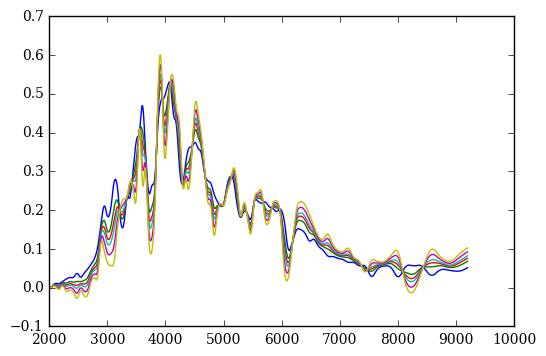

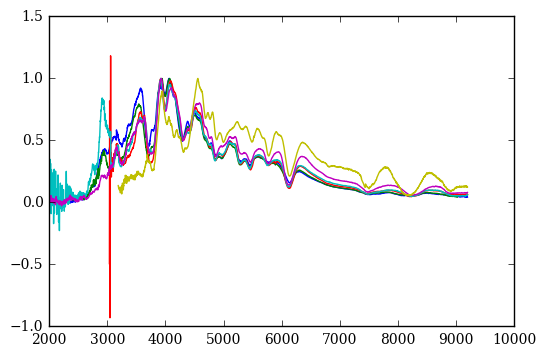

In [95]:
for s in s_temps:
    plt.plot(s.wavelength[s.x1:s.x2], s.flux[s.x1:s.x2])
plt.show()
for comp in comps_dm15_max_mean:
    plt.plot(comp.wavelength[s.x1:s.x2], comp.flux[s.x1:s.x2])
plt.show()

In [40]:
comp_B = []
comp_V = []
query_db.set_min_num_spec(comps_dm15_max_mean, 5)
for comp in comps_dm15_max_mean:
    Bflux = B.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
    Vflux = V.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
    Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag
    Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag
#     Bmag = -2.5 * np.log10(Bflux) - B.AB_zero_mag
#     Vmag = -2.5 * np.log10(Vflux) - V.AB_zero_mag
    comp_B.append(Bmag)
    comp_V.append(Vmag)

In [41]:
boot_BmVs = []
for boots in boot_sn_arrays_mean:
    boot_B = []
    boot_V = []
    for b in boots:
        Bflux = B.get_flux(b.wavelength[b.x1:b.x2], b.flux[b.x1:b.x2], axis = -1)
        Vflux = V.get_flux(b.wavelength[b.x1:b.x2], b.flux[b.x1:b.x2], axis = -1)
        Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag
        Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag
    #     Bmag = -2.5 * np.log10(Bflux) - B.AB_zero_mag
    #     Vmag = -2.5 * np.log10(Vflux) - V.AB_zero_mag
        boot_B.append(Bmag)
        boot_V.append(Vmag)
    BmV = np.asarray(boot_B) - np.asarray(boot_V)
    boot_BmVs.append(BmV)

C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Program Files\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [68]:
low_errors = []
up_errors = []
boot_resids = []
percentile = erf(1/np.sqrt(2.))
low_pc = 0.5 - percentile*0.5
up_pc = 0.5 + percentile*0.5
for k in range(len(boot_sn_arrays_mean)):
    resids = []
    comp_BmVs = np.asarray(comp_B[k]) - np.asarray(comp_V[k])
    resids.append(boot_BmVs[k] - comp_BmVs)
    resid_sort = np.sort(resids)[0]
    boot_resids.append(resid_sort)
    low_ind = np.round((len(resid_sort)-1) * low_pc).astype(int)
    up_ind = np.round((len(resid_sort)-1) * up_pc).astype(int)
    low_errors.append(np.absolute(resid_sort[low_ind]))
    up_errors.append(resid_sort[up_ind])
errors = [low_errors, up_errors]

In [140]:
dm15_phillips = np.linspace(0.85, 1.7, 500)
B_V_phillips = -0.070+ 0.114*(dm15_phillips - 1.1)

dm15_phillips93 = np.linspace(0.85, 1.9, 500)
B_phillips93 =  -21.726 + 2.698*(dm15_phillips_93)
V_phillips93 =  -20.883 + 1.949*(dm15_phillips_93)
B_V_phillips93 = B_phillips93 - V_phillips93

dm15_garn = np.linspace(1.65, 2.05, 500)
B_V_garn = -3.95+ 2.38*(dm15_garn)

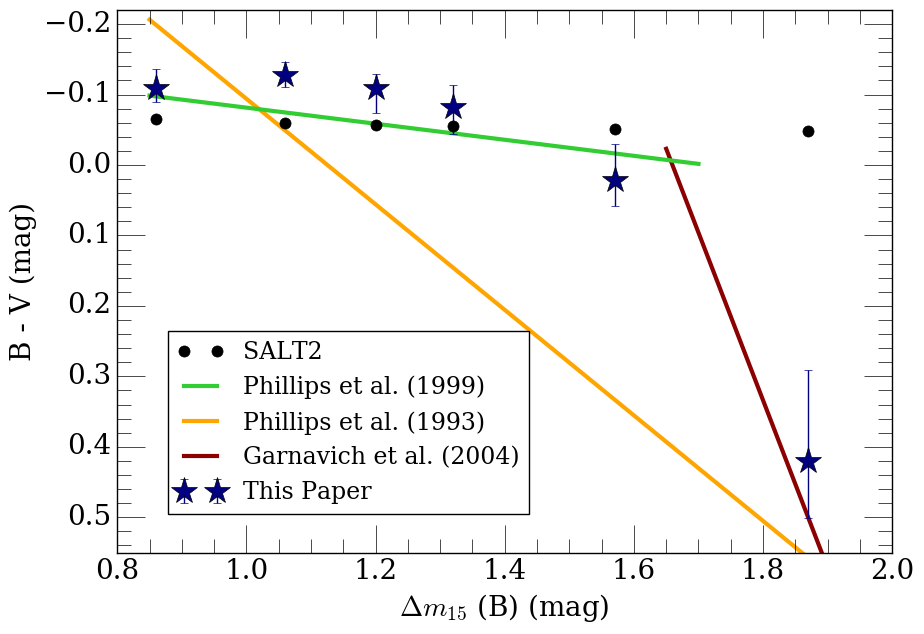

In [141]:
plt.rc('font', family='serif')
plt.figure(num = 1, dpi = 100, figsize = [10,7])
plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('$\Delta m_{15}$ (B) (mag)', fontsize = 20)
plt.ylabel('B - V (mag)', fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=20)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
# plt.plot(c_dm15s, c_B_minus_Vs, 'o', markersize=8, alpha=.6, color = 'magenta', label='CMAGIC')
plt.errorbar(dm15s, np.asarray(comp_B) - np.asarray(comp_V), yerr=errors, fmt='*', markersize=20, color = "#000080", label = 'This Paper')
plt.plot(dm15s, np.asarray(salt_B)-np.asarray(salt_V), 'o', markersize=8, color = 'black', label='SALT2')
plt.plot(dm15_phillips, B_V_phillips, color='limegreen', lw=3, label = 'Phillips et al. (1999)', zorder=1)
plt.plot(dm15_phillips93, B_V_phillips93, color='orange', lw=3, label = 'Phillips et al. (1993)', zorder=.5)
plt.plot(dm15_garn, B_V_garn, color='darkred', lw=3, label = 'Garnavich et al. (2004)', zorder=.2)
plt.xlim([0.8,2.0])
plt.ylim([-.22, .55])
plt.legend(loc=3, bbox_to_anchor=(0.05, 0.05, 0.48, 0.5), fontsize=17)
plt.gca().invert_yaxis()
# plt.savefig('../../../Paper_Drafts/main_composites_updated/color_dm15.pdf')
plt.show()